In [26]:
!pip install keras-tuner
!pip install tensorflow_addons
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import tensorflow_addons as tfa

In [27]:
import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [28]:
#Importing Input data
data_cohesion = np.load('Inputs/4ft_cohesion.npy')
data_friction = np.load('Inputs/4ft_friction.npy')
data_poly = np.load('Inputs/4ft_poly_feature.npy')
data_watertable = np.load('Inputs/4ft_water_table.npy')
data_velo = np.load("Targets/4ft_velocity_plots.npy")
data_watertable = np.squeeze(data_watertable)

In [29]:
#Size
data_cohesion = np.transpose(data_cohesion)
data_friction = np.transpose(data_friction)
data_watertable = np.transpose(data_watertable)
data_watertable = np.squeeze(data_watertable)
print(np.shape(data_cohesion))
print(np.shape(data_friction))
print(np.shape(data_watertable))
print(np.shape(data_velo))
m = np.shape(data_cohesion)[1]
n_sim = np.shape(data_velo)[2]
n_final_test = 0
n_remain = n_sim - n_final_test
mo = np.shape(data_velo)[0]

(144807, 16)
(144807, 16)
(144807,)
(33, 33, 144807)


In [30]:
li= []
for i in range (n_sim):
    temp = np.reshape(data_velo[:,:,i],(mo*mo,1))
    li.append(temp)
data = np.array(li)

In [31]:
data_arr= np.zeros((n_remain,2*m + 1))
data_arr[0:n_remain,0:m] = data_cohesion[0:n_remain,:]
data_arr[0:n_remain,m:2*m] = data_friction[0:n_remain,:]
data_arr[0:n_remain,2*m] = data_watertable[0:n_remain]

In [32]:
data_x = data_arr
data_y = data[0:n_remain,:,:]
data_y = np.reshape(data_y, (n_remain,mo*mo))

In [33]:
np.shape(data_y)

(144807, 1089)

In [34]:
np.shape(data_arr)

(144807, 33)

In [35]:
def build_model(hp):
    
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 3, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=512,
                                            max_value=4068,
                                            step=64),
                               activation='relu'))
    model.add(layers.Dense(1089, activation='linear'))
    metric = tfa.metrics.r_square.RSquare()
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics='mean_squared_error')
    return model

In [36]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Velocity Field')

INFO:tensorflow:Reloading Oracle from existing project project\Velocity Field\oracle.json


In [37]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 4068, 'step': 64, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 4068, 'step': 64, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 4068, 'step': 64, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [38]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.1, random_state = 42)

In [39]:
tuner.search(x_train, y_train,
             epochs=100,
             validation_data=(x_test, y_test))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
6                 |?                 |num_layers
1920              |?                 |units_0
3328              |?                 |units_1
1856              |?                 |units_2
0.001             |?                 |learning_rate

Epoch 1/100
4073/4073 [==============================] - 31s 8ms/step - loss: 2.3859 - mean_squared_error: 7000.8042 - val_loss: 1.0906e-04 - val_mean_squared_error: 1.9278e-08
Epoch 2/100
4073/4073 [==============================] - 32s 8ms/step - loss: 1.1201e-04 - mean_squared_error: 2.0381e-08 - val_loss: 1.1792e-04 - val_mean_squared_error: 2.1924e-08
Epoch 3/100
4073/4073 [==============================] - 34s 8ms/step - loss: 1.1208e-04 - mean_squared_error: 2.0422e-08 - val_loss: 1.1172e-04 - val_mean_squared_error: 2.0645e-08
Epoch 4/100
4073/4073 [==============================] - 34s 8ms/step - loss: 1.1211e-04 - mean_squared_error: 2.0441e-08 - val_loss: 1.108

4073/4073 [==============================] - 61s 15ms/step - loss: 1.1330e-04 - mean_squared_error: 2.0773e-08 - val_loss: 1.1156e-04 - val_mean_squared_error: 2.0088e-08
Epoch 43/100
4073/4073 [==============================] - 62s 15ms/step - loss: 1.1352e-04 - mean_squared_error: 2.0834e-08 - val_loss: 1.1471e-04 - val_mean_squared_error: 2.1563e-08
Epoch 44/100
4073/4073 [==============================] - 62s 15ms/step - loss: 1.1301e-04 - mean_squared_error: 2.0717e-08 - val_loss: 1.0987e-04 - val_mean_squared_error: 1.9470e-08
Epoch 45/100
4073/4073 [==============================] - 62s 15ms/step - loss: 1.1346e-04 - mean_squared_error: 2.0838e-08 - val_loss: 1.0799e-04 - val_mean_squared_error: 1.9267e-08
Epoch 46/100
4073/4073 [==============================] - 61s 15ms/step - loss: 1.1327e-04 - mean_squared_error: 2.0749e-08 - val_loss: 1.1107e-04 - val_mean_squared_error: 2.0109e-08
Epoch 47/100
4073/4073 [==============================] - 62s 15ms/step - loss: 1.1391e-04 - 

KeyboardInterrupt: 

In [ ]:
tunes.result_summary()

In [11]:
y_pred = ann1.predict(x_test)
y_pred = sc.inverse_transform(y_pred)
y_actual = sc.inverse_transform(y_test)
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2 = r2_score(y_actual,y_pred)
r2

906/906 [==============================] - 2s 2ms/step


0.6543499371097048

In [12]:
np.shape(y_pred[0,:])

(1089,)

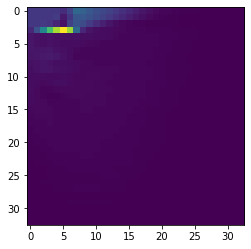

In [13]:
a = np.reshape(y_pred[0,:],(33,33))
plt.imshow(a)

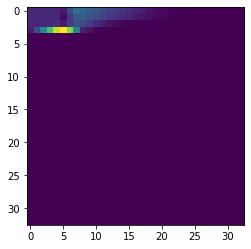

In [14]:
b = np.reshape(y_actual[0,:],(33,33))
plt.imshow(b)

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model